<a href="https://colab.research.google.com/github/austinyu2019/practice_deeplearning/blob/master/pytoch/gan/gan_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable

import torchvision
import torchvision.transforms as transforms

In [2]:
# Preprocessing
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Training data
train_set = torchvision.datasets.MNIST(root='.',
                                      train=True,
                                      download=True,
                                      transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=32,
                                          shuffle=True)

# Labels
classes = [str(i) for i in range(0,10)]

0it [00:00, ?it/s]

9920512it [00:02, 3538025.57it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 56647.66it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:01, 865397.51it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 21103.75it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [0]:
# Our Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out.cuda()
        
discriminator = Discriminator()

In [0]:
# Our Generator class
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x).cuda()
        return out

generator = Generator()

In [5]:
# If we have a GPU with CUDA, use it
if torch.cuda.is_available():
    print("Using CUDA")
    discriminator.cuda()
    generator.cuda()

# Setup loss function and optimizers
lr = 0.0001
num_epochs = 40
num_batches = len(train_loader)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

Using CUDA


In [0]:
#  描绘生成器生成图像 
import matplotlib.pyplot as plt
# from IPython.display import clear_output as clear
def plot_gen(fake_images,n_ex=16,dim=(4,4), figsize=(10,10) ):
    plt.figure(figsize=figsize)
    for i in range(16):
        plt.subplot(dim[0],dim[1],i+1)
        img = fake_images.cpu().detach().numpy()[i].reshape(28,28)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
#     clear()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


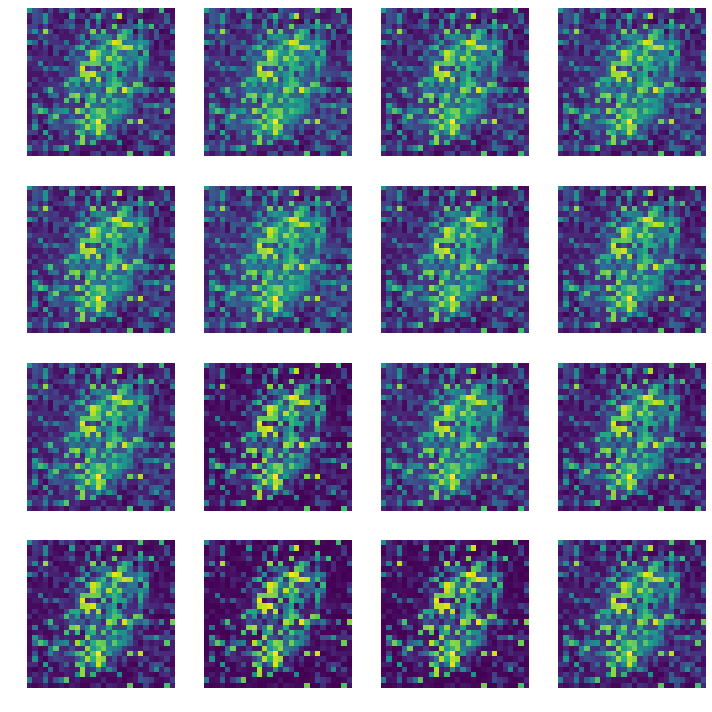

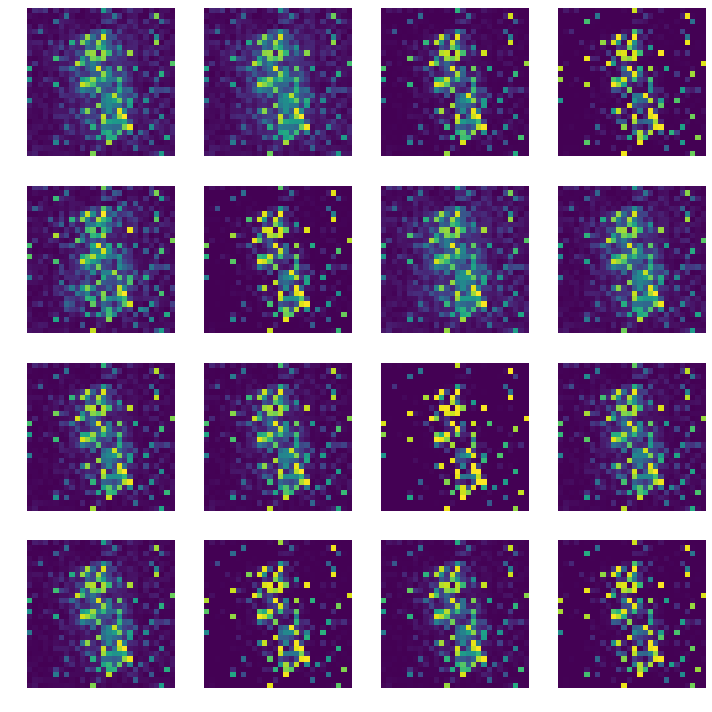

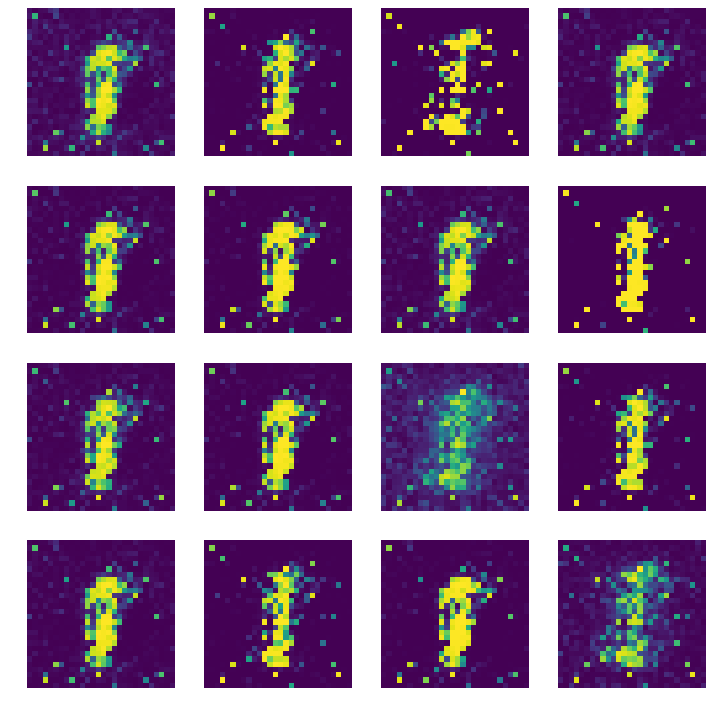

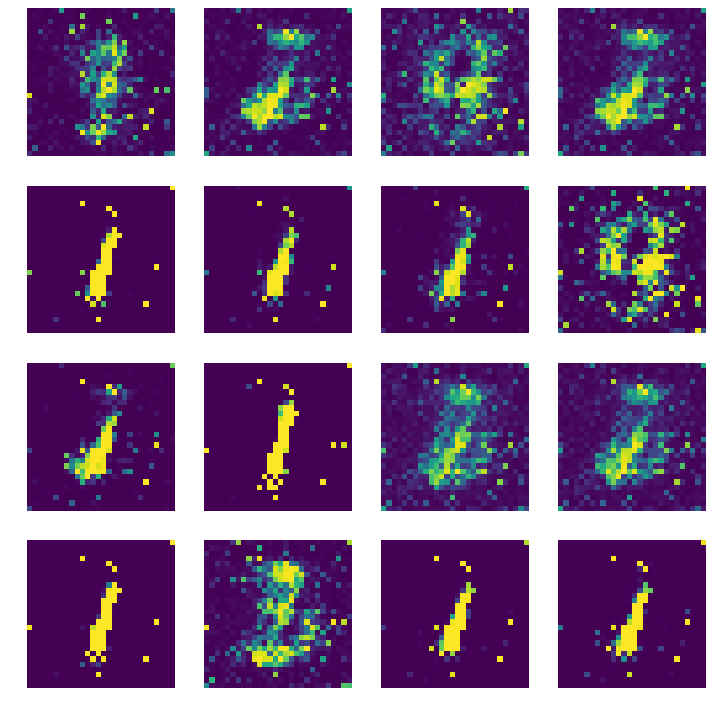

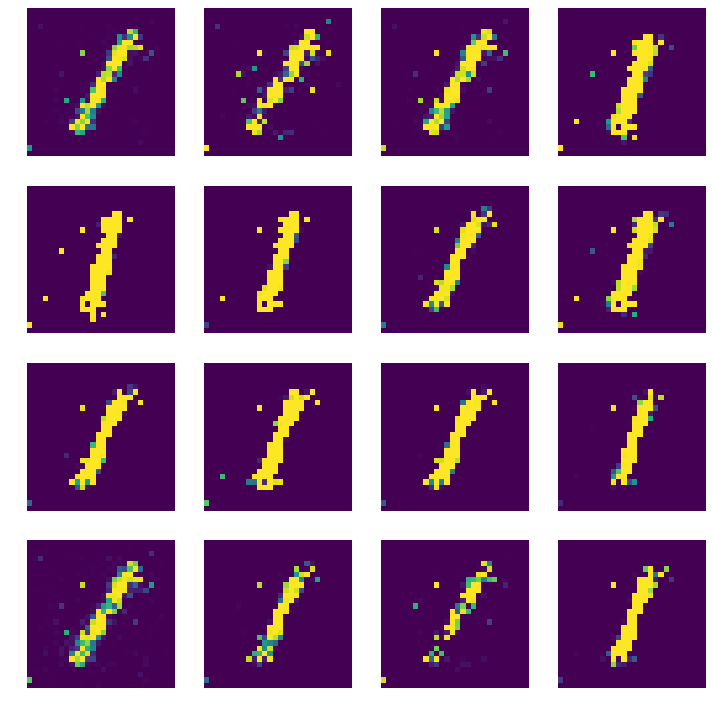

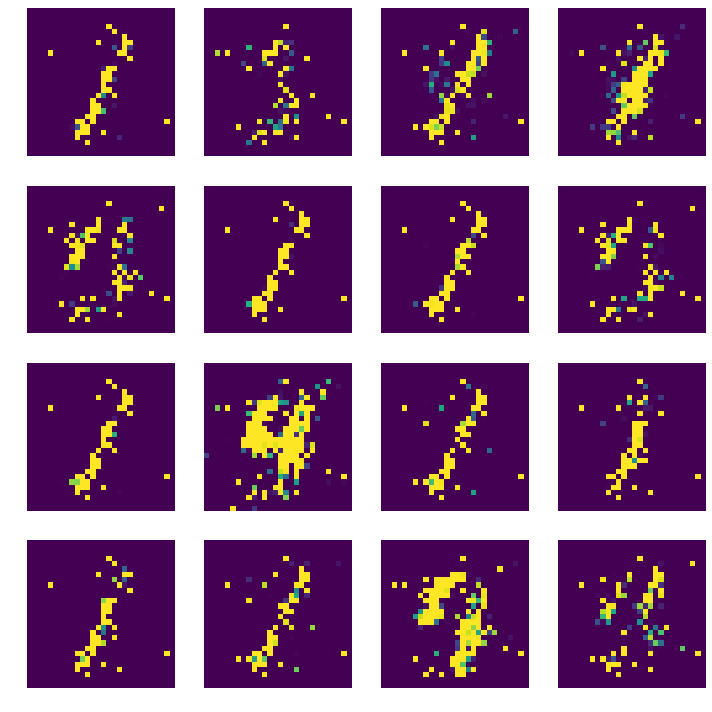

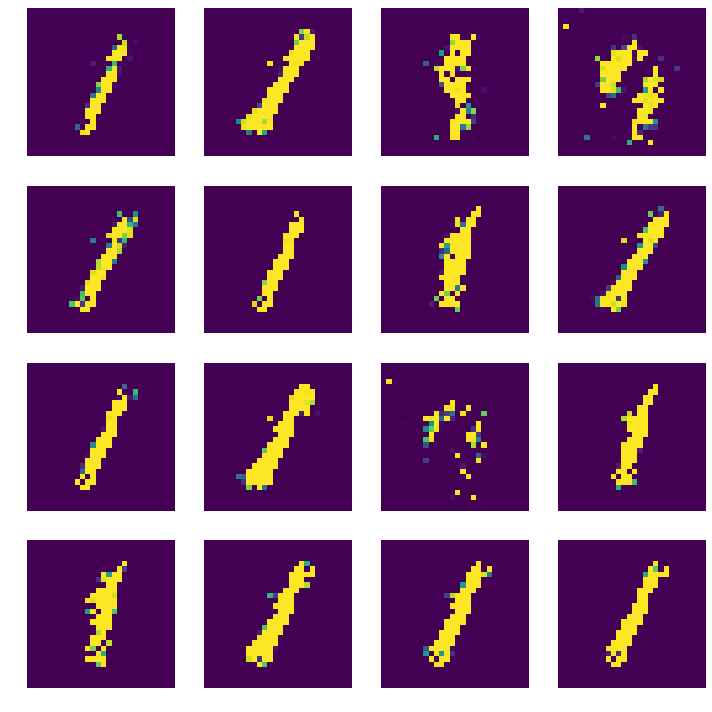

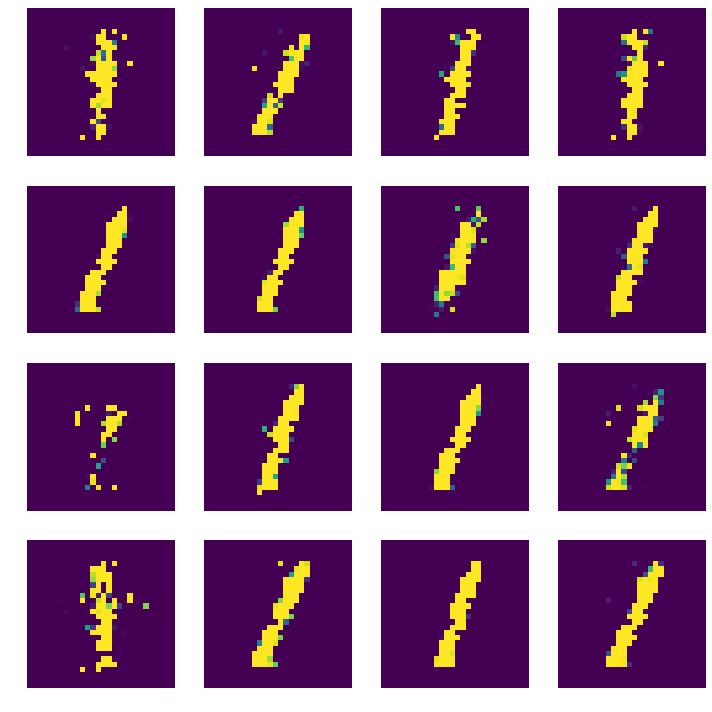

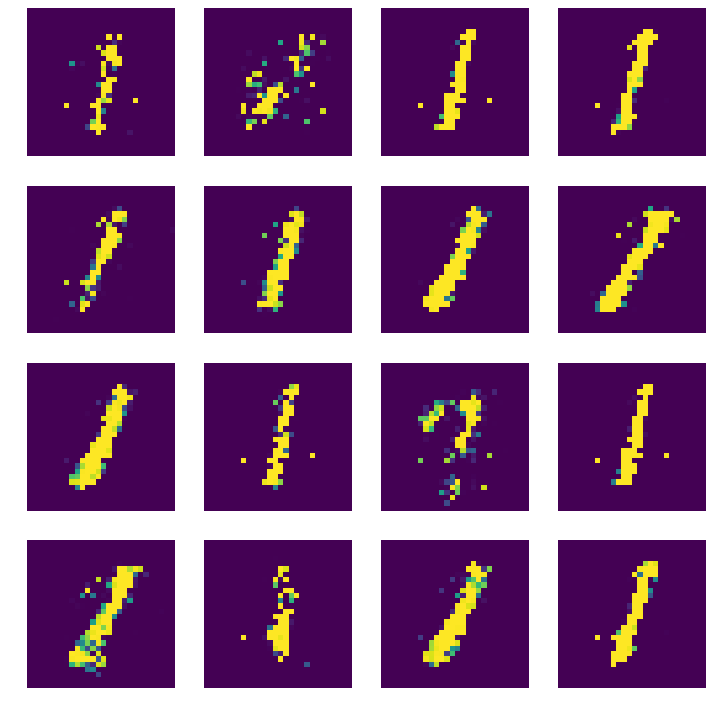

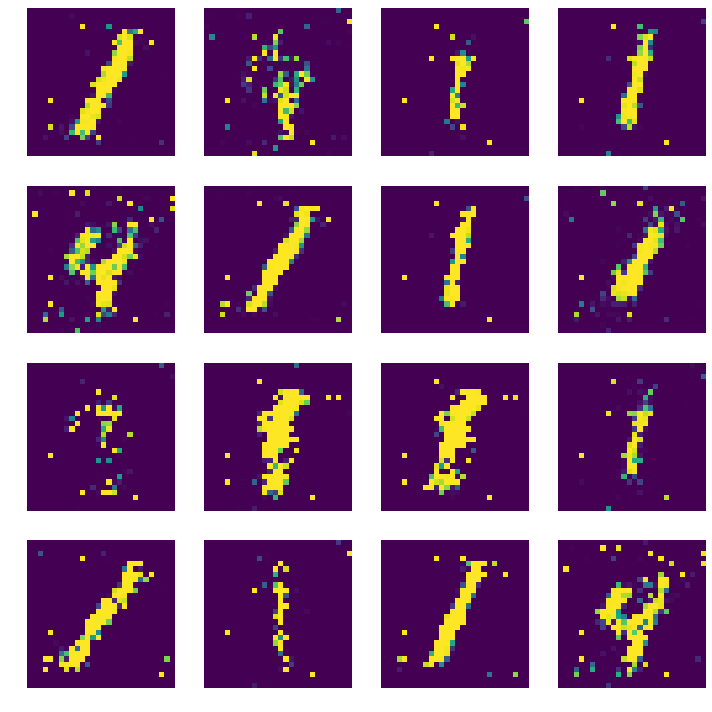

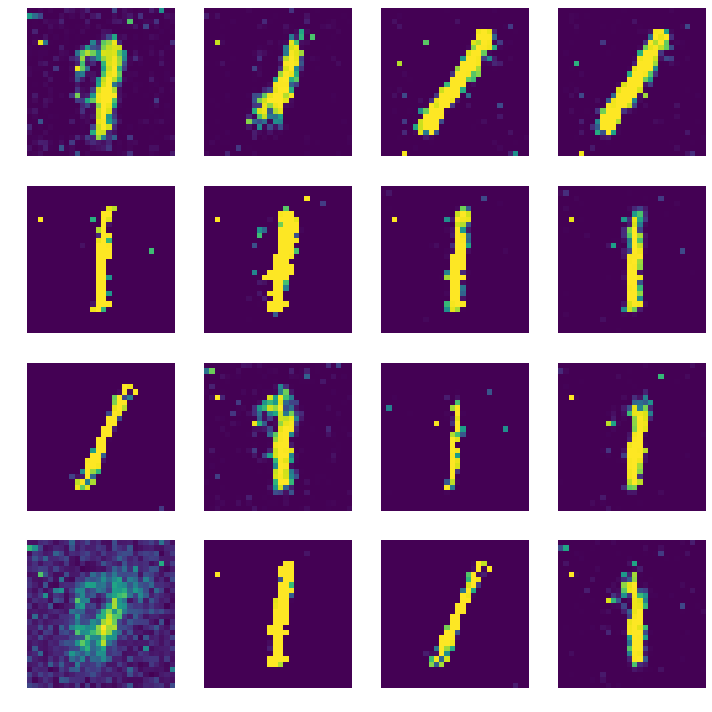

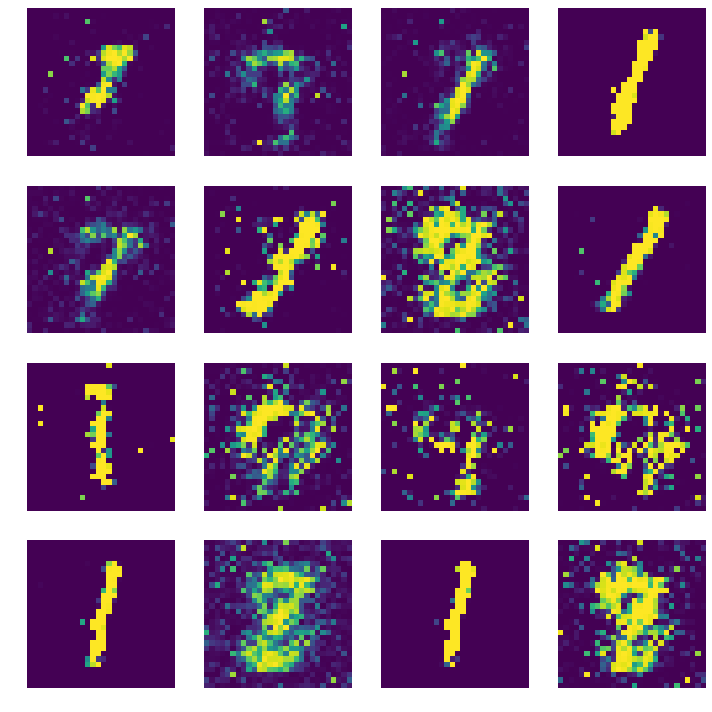

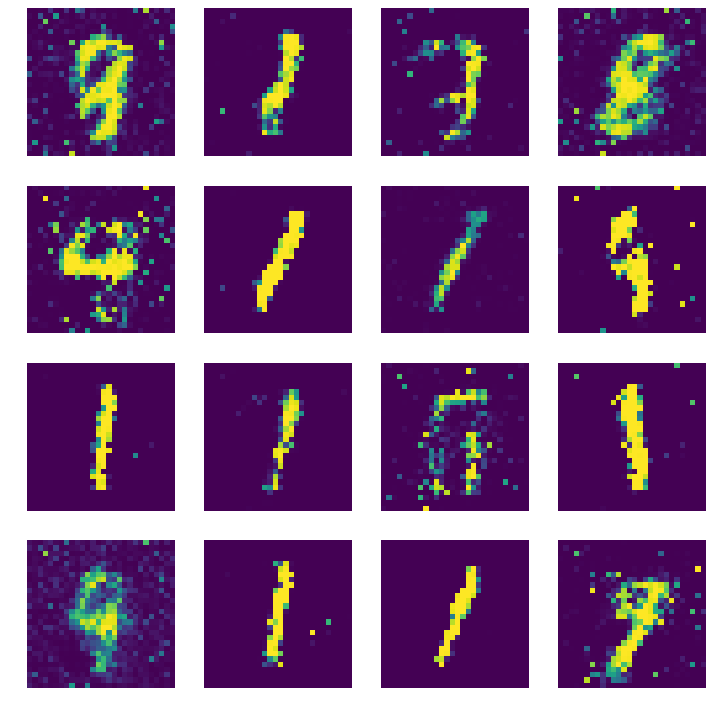

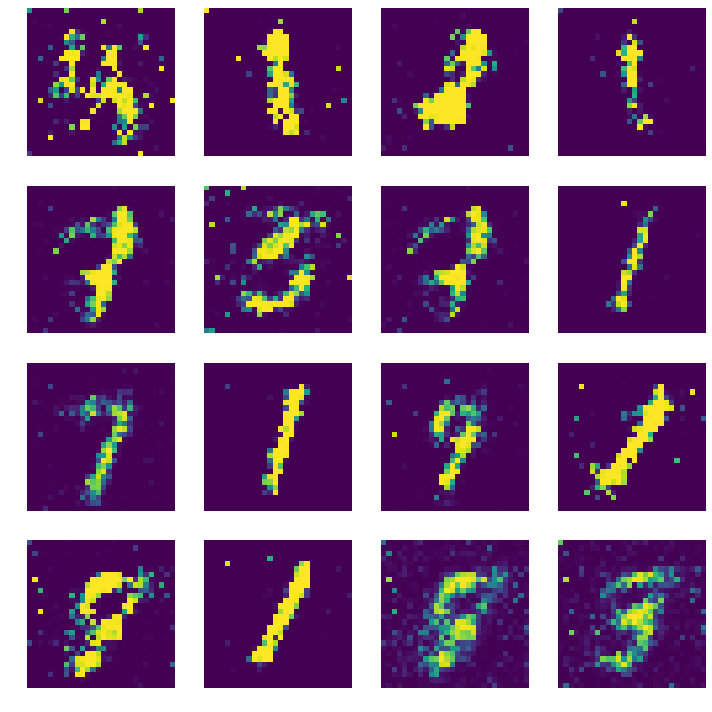

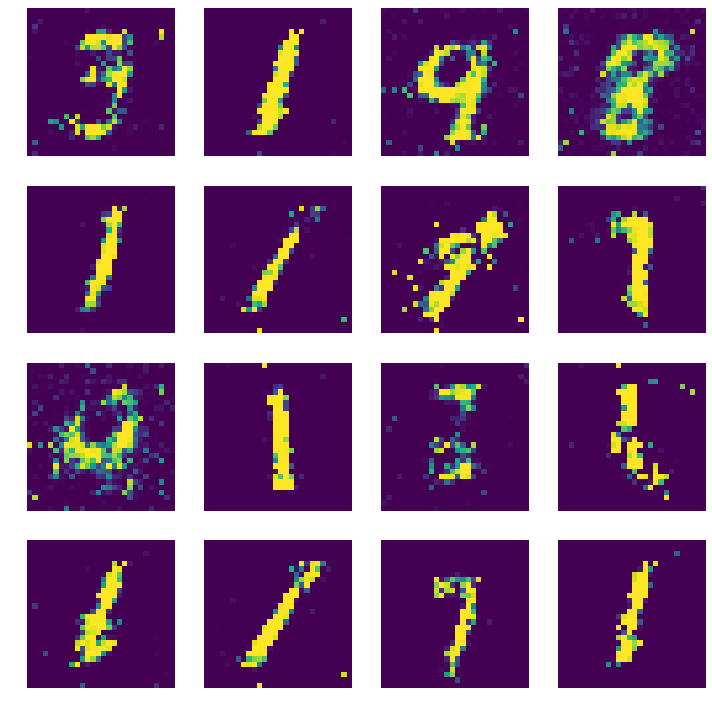

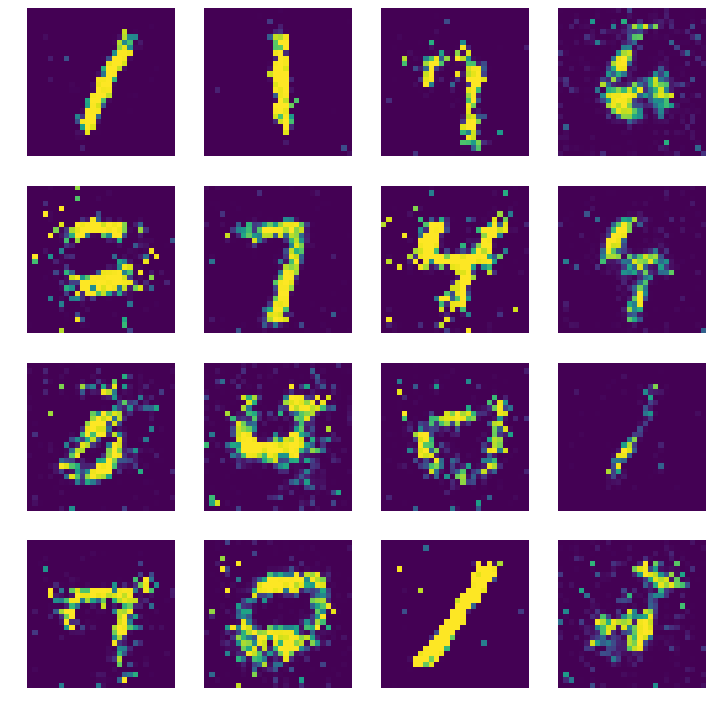

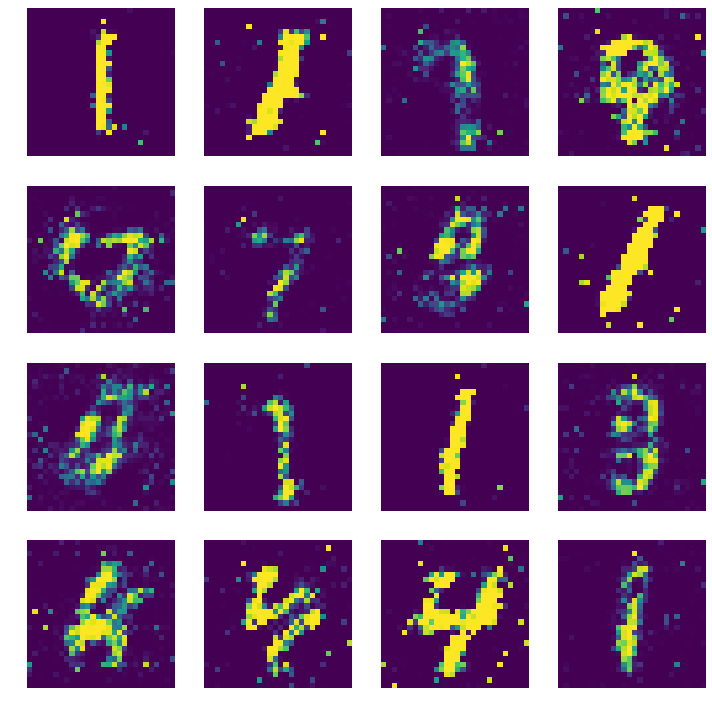

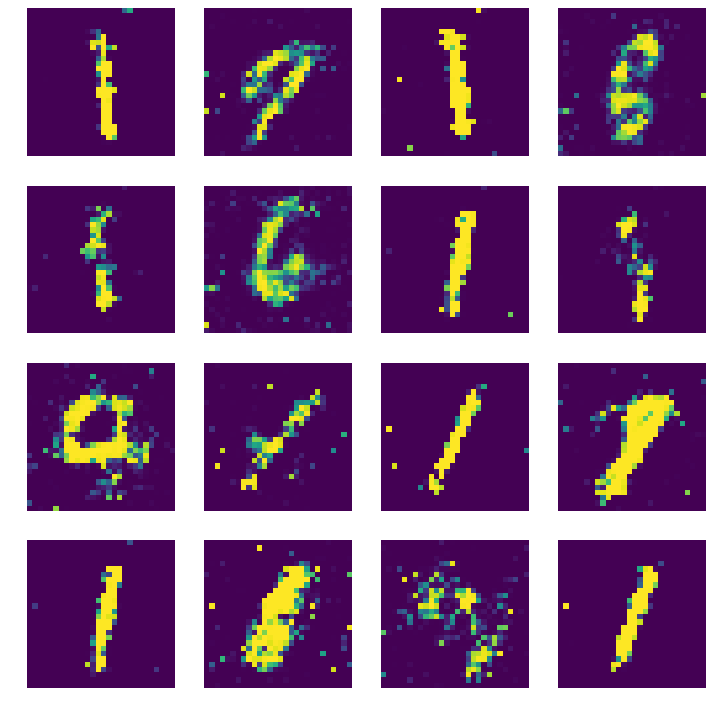

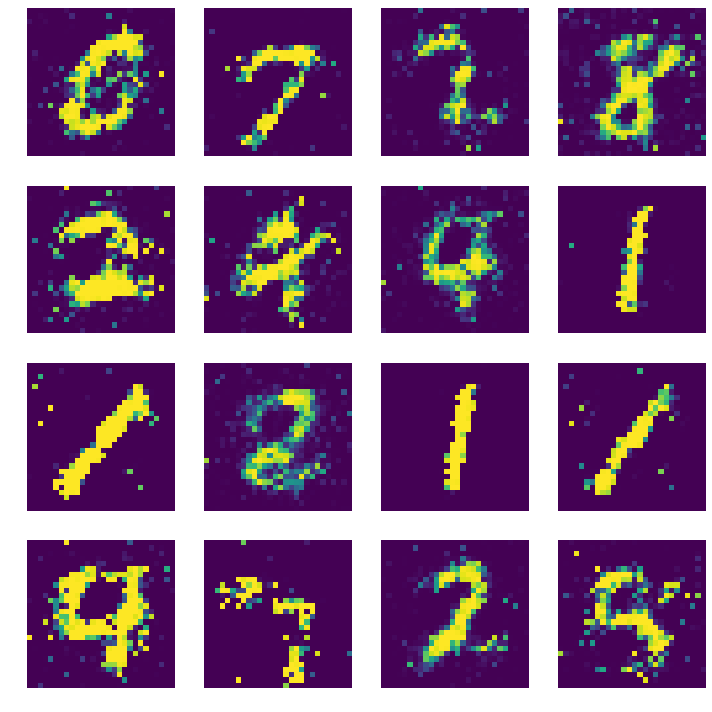

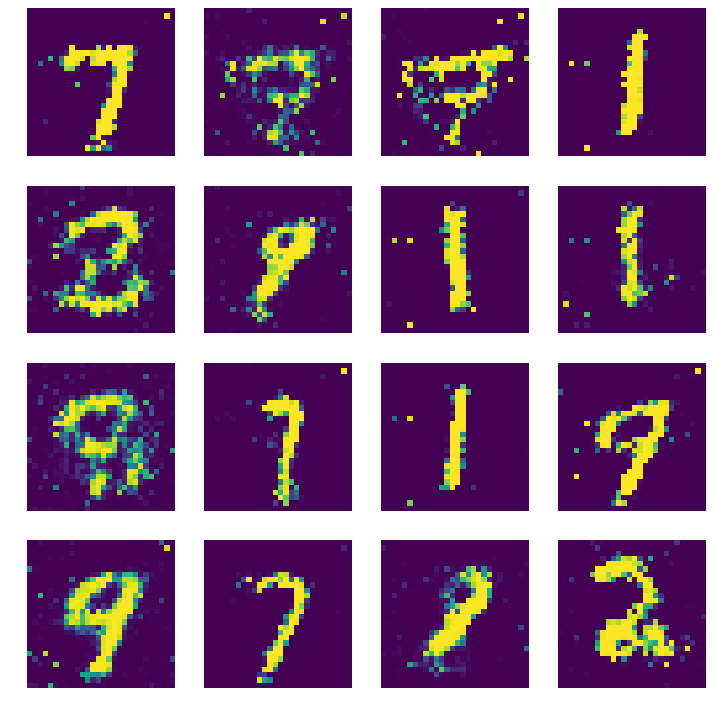

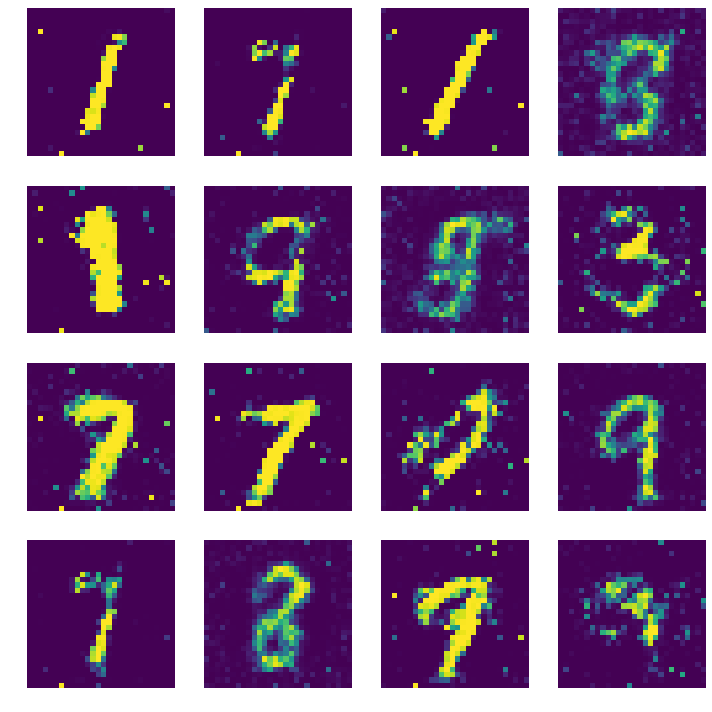

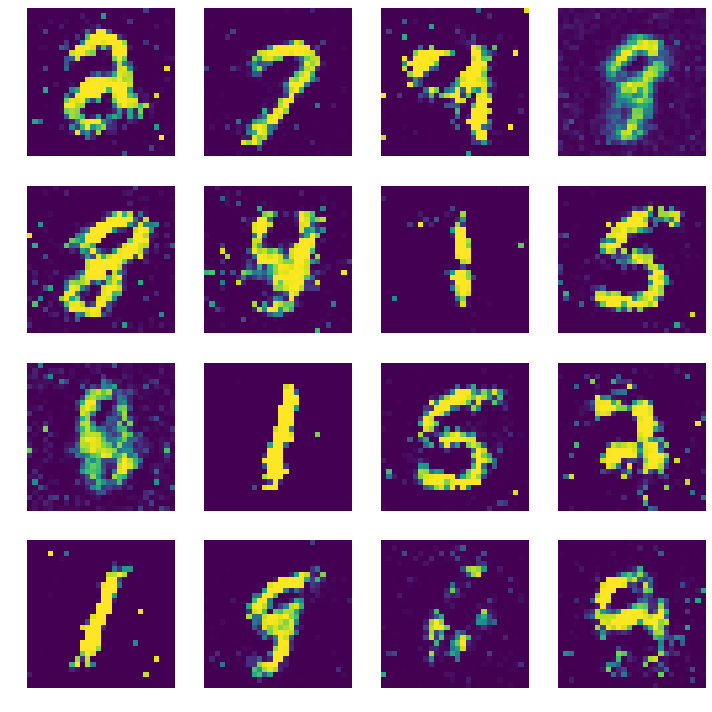

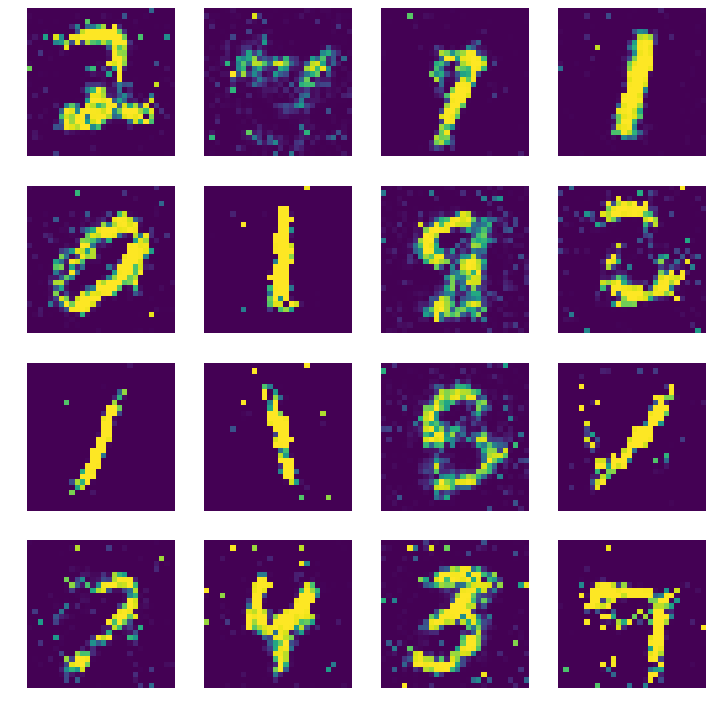

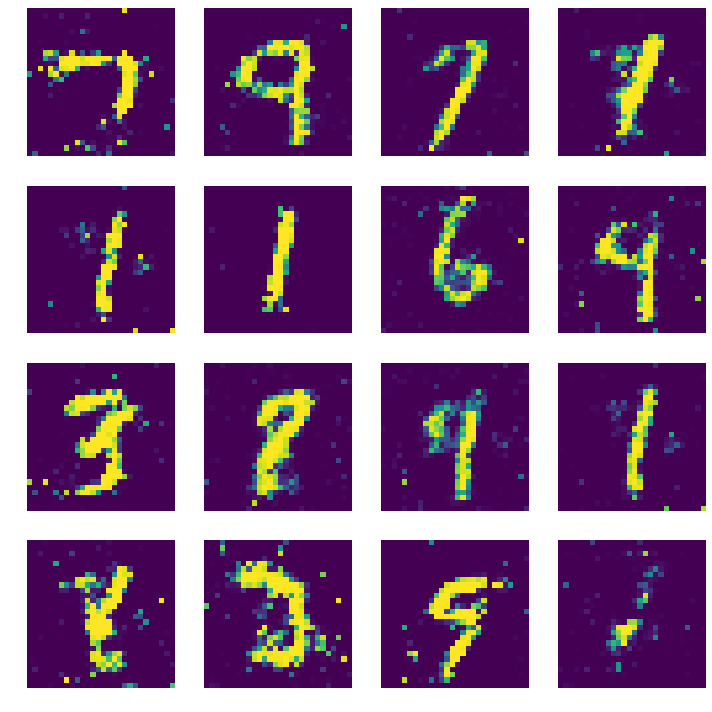

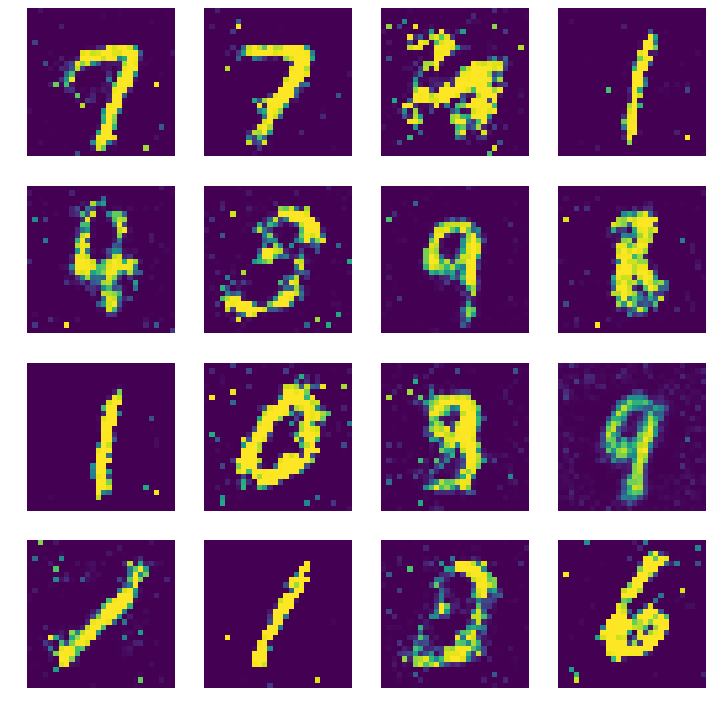

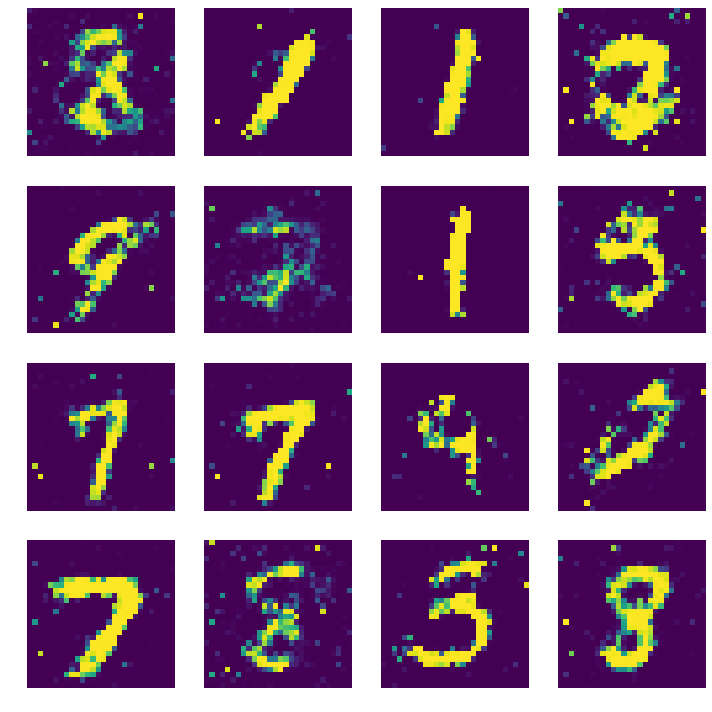

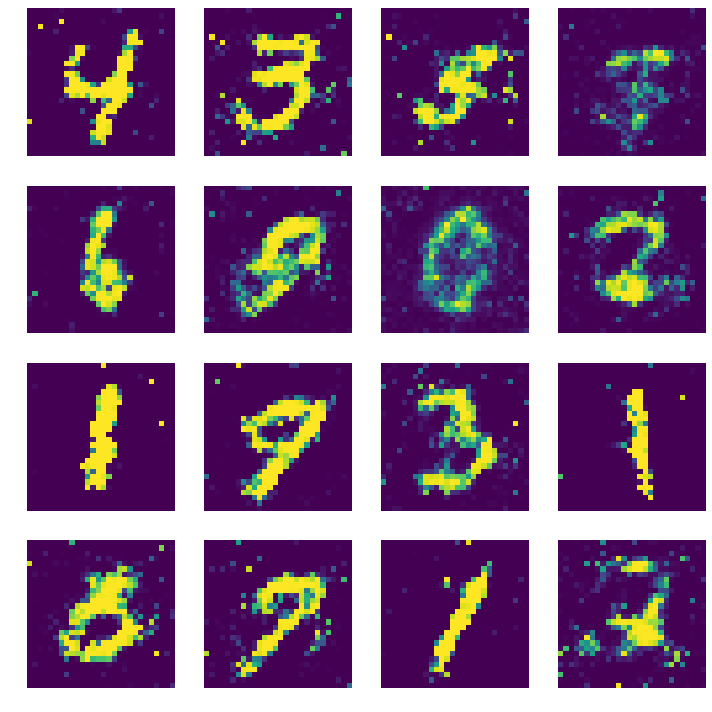

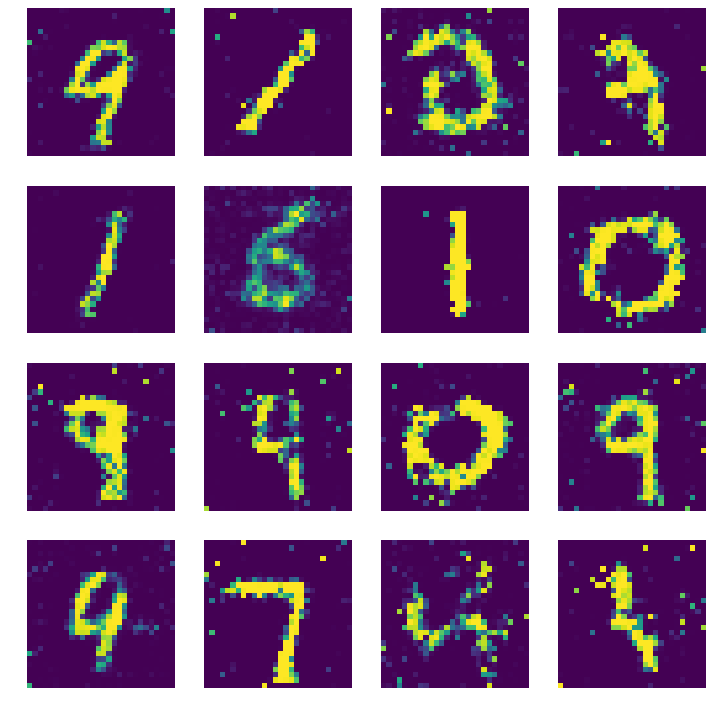

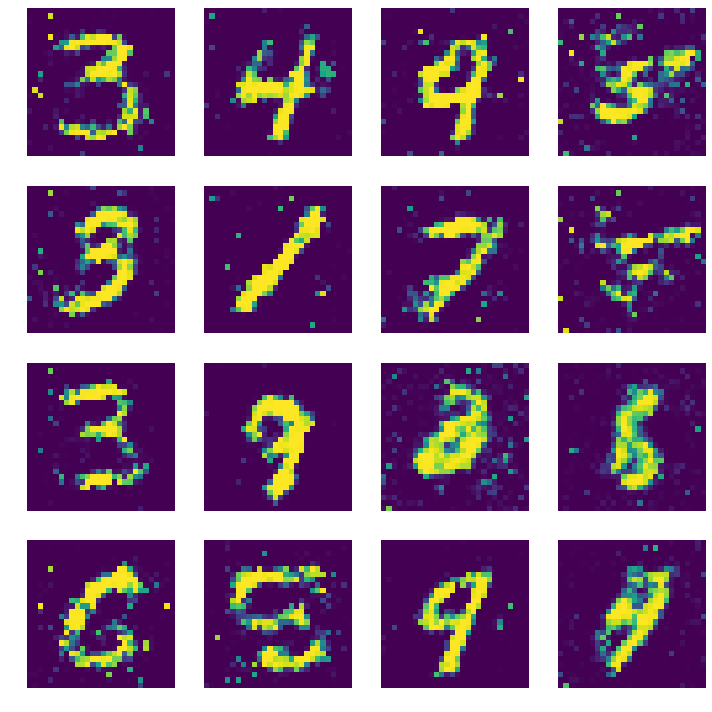

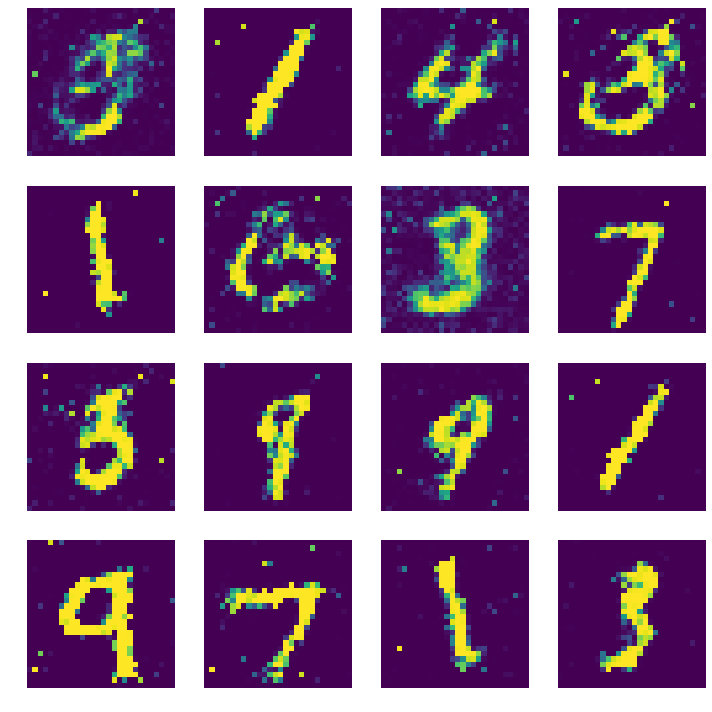

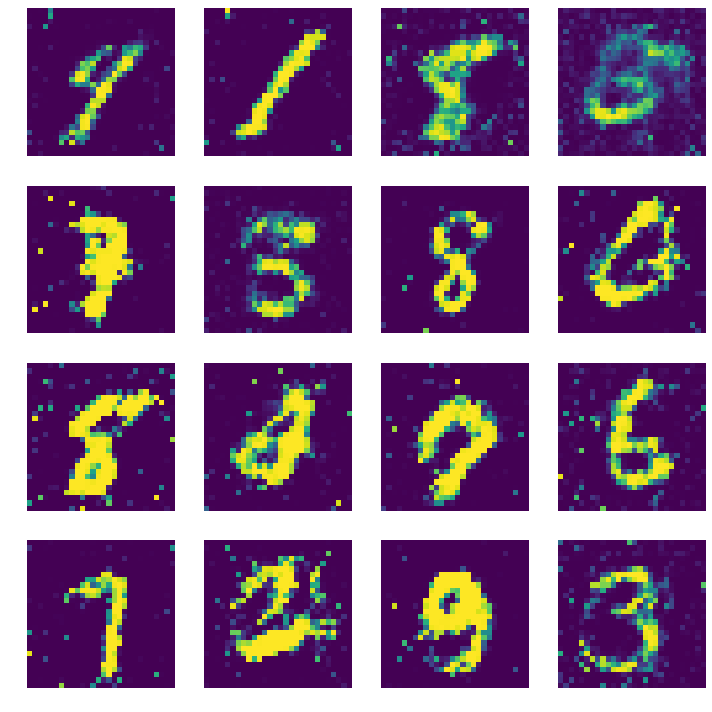

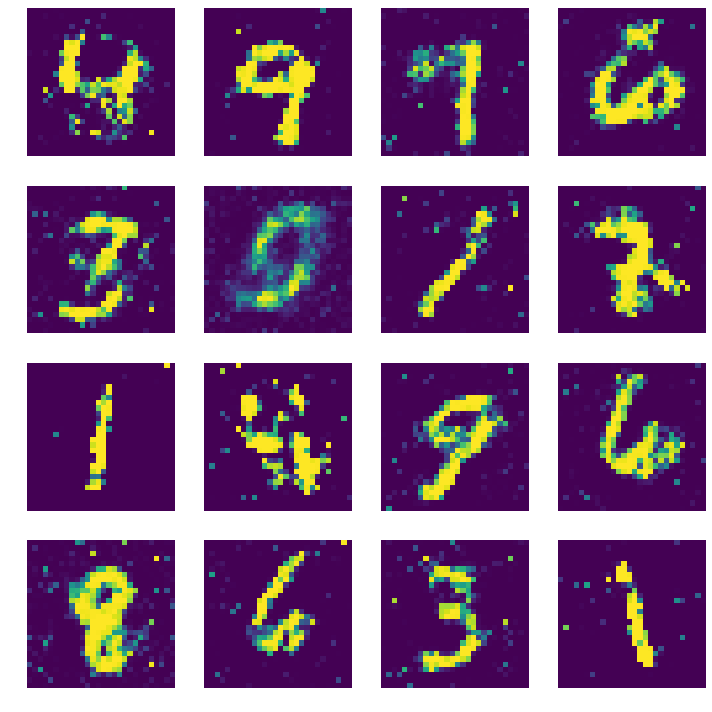

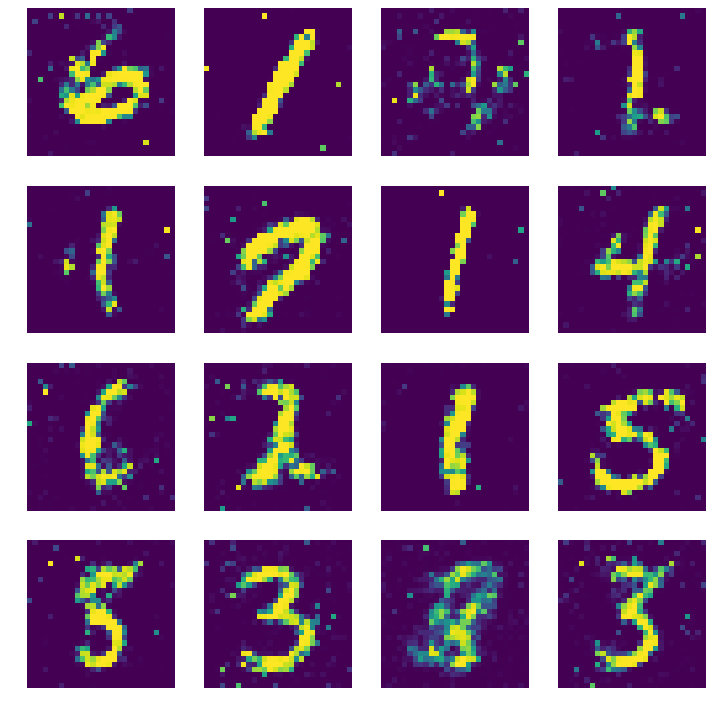

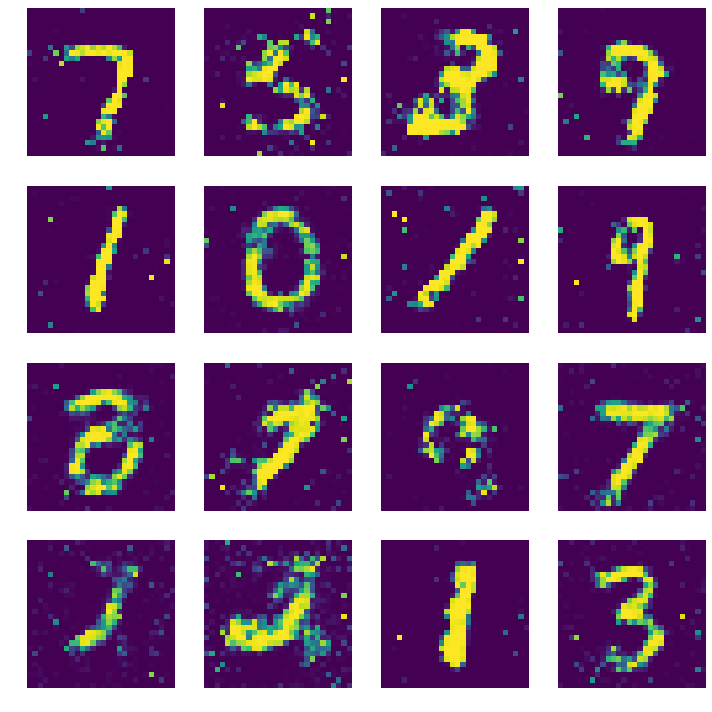

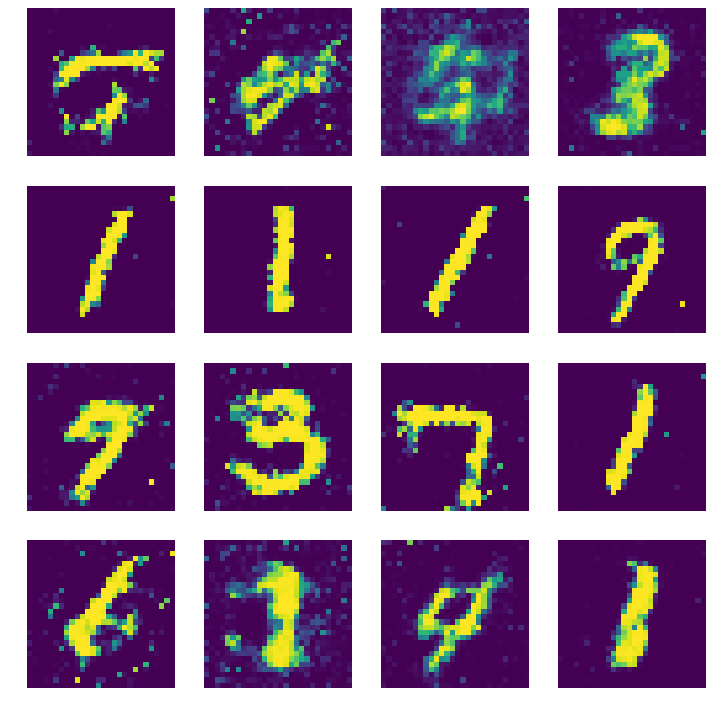

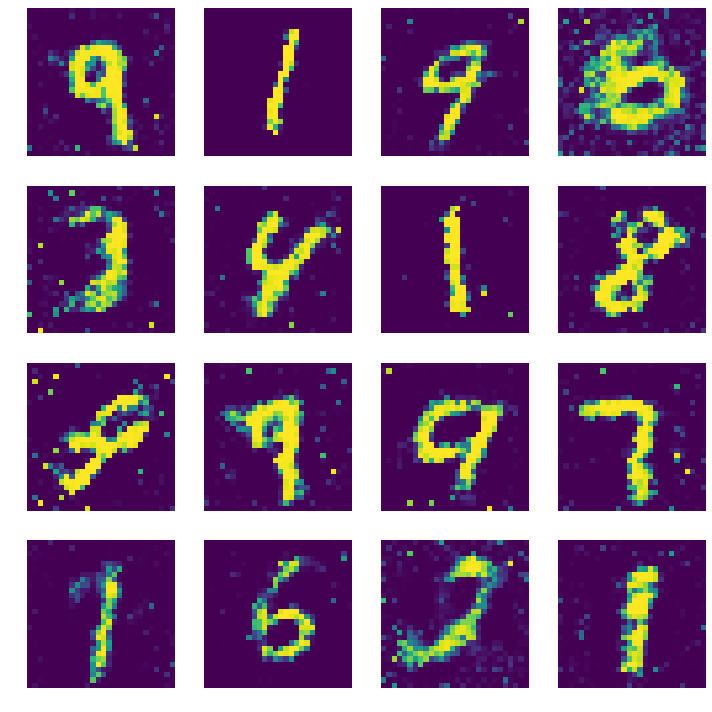

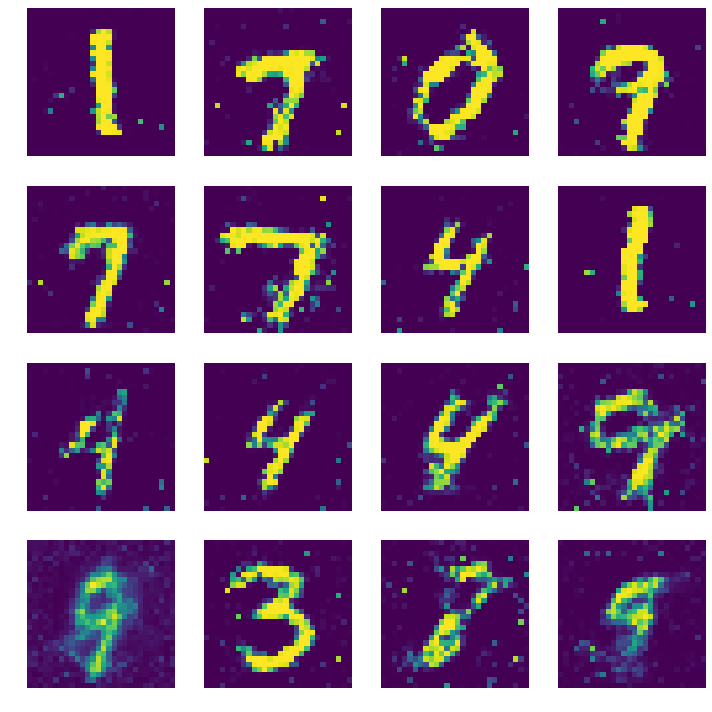

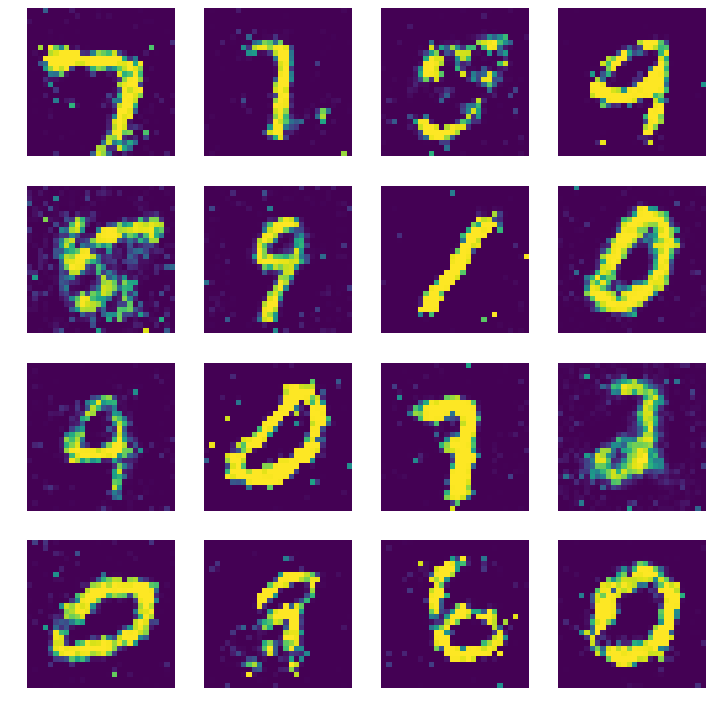

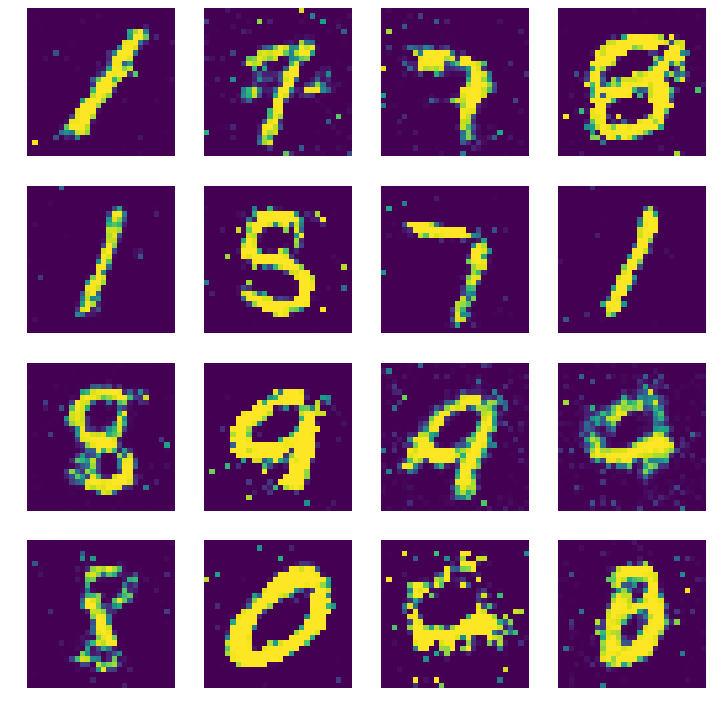

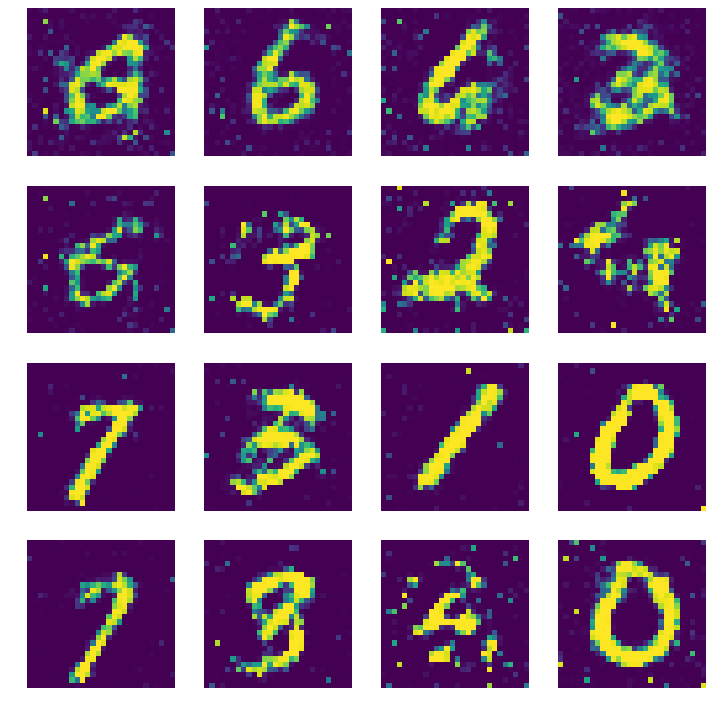

In [41]:
# Convenience function for training our Discriminator
def train_discriminator(discriminator, real_images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()

    # Get the predictions, loss, and score of the real images
    predictions = discriminator(real_images)
    real_loss = criterion(predictions, real_labels)
    real_score = predictions

    # Get the predictions, loss, and score of the fake images
    predictions = discriminator(fake_images)
    fake_loss = criterion(predictions, fake_labels)
    fake_score = predictions

    # Calculate the total loss, update the weights, and update the optimizer
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

# Convenience function for training our Generator
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()

    # Calculate the total loss, update the weights, and update the optimizer
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss
    
for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):

        # (1) Prepare the real data for the Discriminator
        real_images = Variable(images).cuda()
        real_labels = Variable(torch.ones(images.size(0))).cuda()

        # (2) Prepare the random noise data for the Generator
        noise = Variable(torch.randn(images.size(0), 100)).cuda()

        # (3) Prepare the fake data for the Discriminator
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0))).cuda()

        # (4) Train the discriminator on real and fake data
        d_loss, real_score, fake_score = train_discriminator(discriminator,
                                                             real_images, real_labels,
                                                             fake_images, fake_labels)

        # (5a) Generate some new fake images from the Generator.
        # (5b) Get the label predictions of the Discriminator on that fake data.
        noise = Variable(torch.randn(images.size(0), 100)).cuda()
        fake_images = generator(noise)
        

        outputs = discriminator(fake_images)

        # (6) Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
    plot_gen(fake_images)

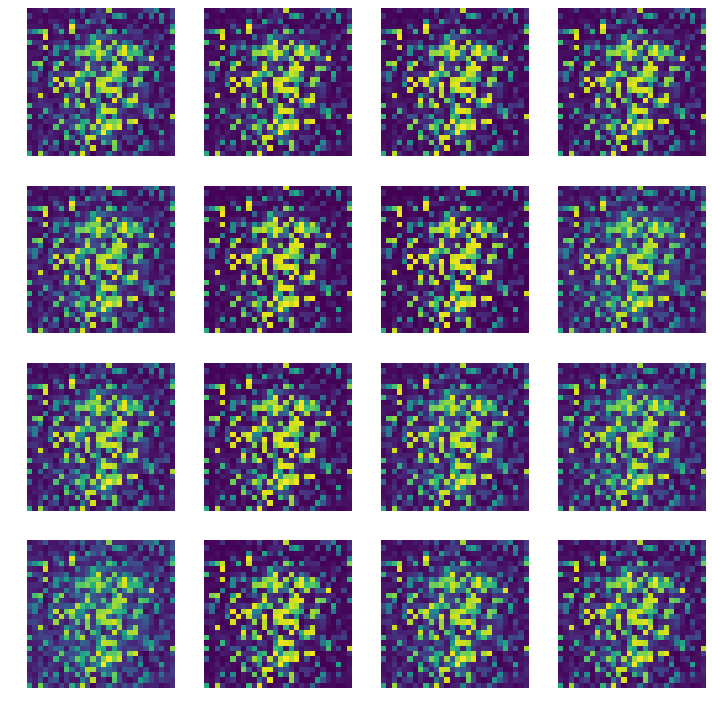

In [33]:
plot_gen(fake_images)


In [36]:
fake_images.cpu().detach().numpy()[0][0:10]

array([-0.9422768 , -0.91199493, -0.86383206, -0.5948851 , -0.9209782 ,
       -0.92316467, -0.8578954 , -0.911212  , -0.6955688 , -0.8701848 ],
      dtype=float32)

In [39]:
fake_images.cpu().detach().numpy()[20][0:10]

array([-0.89269143, -0.85565627, -0.7790469 , -0.51648045, -0.8692281 ,
       -0.8667494 , -0.7945839 , -0.84987855, -0.6027666 , -0.7973211 ],
      dtype=float32)

In [17]:
fake_images.cpu().detach().numpy().shape

(32, 784)

参考网站https://www.yanxishe.com/TextTranslation/2134

In [21]:
fake_images.shape[0]

32

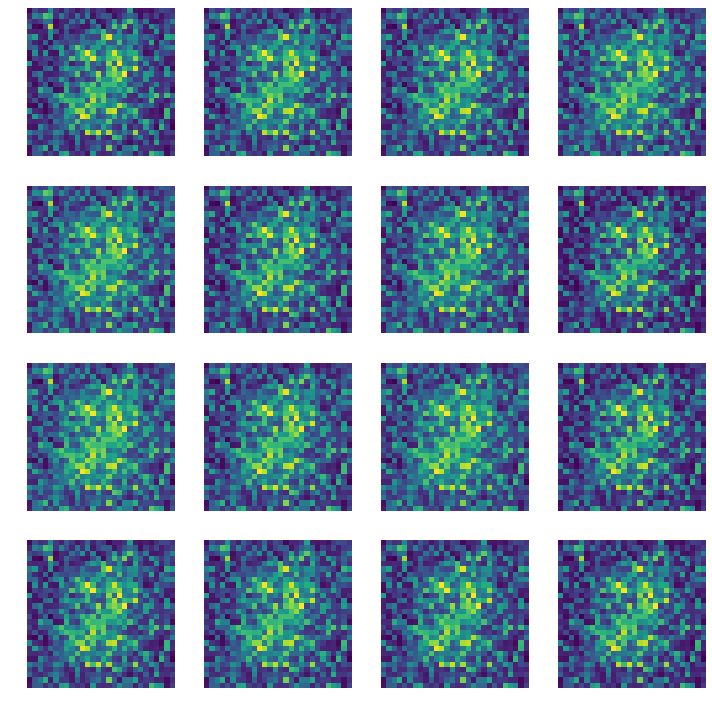